In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import nltk

In [3]:
one = "The best Monty Python sketch is the one about the dead parrot,  I laughed so hard."
two = "I laugh when I think about Python's Ministry of Silly Walks sketch, it is funny, funny, funny, the best!"
three ="Chocolate is the best ice cream dessert topping, with a great taste."
four = "The Lumberjack Song is the funniest Monty Python bit: I can't think of it without laughing."
five = "I would rather put strawberries on my ice cream for dessert, they have the best taste."
six = "The taste of caramel is a fantastic accompaniment to tasty mint ice cream."

combined = [one, two, three, four, five, six]

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
vector = vectorizer.fit_transform(combined)

columns = vectorizer.get_feature_names()

X = pd.DataFrame(vector.toarray(), columns=columns)
y = ['comedy', 'comedy', 'ice_cream', 'comedy', 'ice_cream', 'ice_cream']

In [5]:
X

,accompaniment,best,bit,caramel,chocolate,cream,dead,dessert,fantastic,funniest,...,python,silly,sketch,song,strawberries,taste,tasty,think,topping,walks
0,0.00000,0.238719,0.000000,0.00000,0.000000,0.000000,0.402386,0.000000,0.00000,0.000000,...,0.278577,0.000000,0.329962,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,0.00000,0.152288,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.177714,0.256696,0.210495,0.000000,0.000000,0.000000,0.00000,0.210495,0.000000,0.256696
2,0.00000,0.253839,0.000000,0.00000,0.427872,0.296221,0.000000,0.350861,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.296221,0.00000,0.000000,0.427872,0.000000
3,0.00000,0.000000,0.382804,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.382804,...,0.265020,0.000000,0.000000,0.382804,0.000000,0.000000,0.00000,0.313904,0.000000,0.000000
4,0.00000,0.318834,0.000000,0.00000,0.000000,0.372067,0.000000,0.440698,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.537427,0.372067,0.00000,0.000000,0.000000,0.000000
5,0.39412,0.000000,0.000000,0.39412,0.000000,0.272854,0.000000,0.000000,0.39412,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.272854,0.39412,0.000000,0.000000,0.000000


In [15]:
from sklearn.decomposition import PCA
from nltk.corpus import gutenberg
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')

emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.21366597234673
Component 0:
" Oh !     0.999289
" Oh !     0.999289
" Oh !"    0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634053
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.577296
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.565415
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elto

__Test Set:__

In [21]:
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 49.39215276176464
Component 0:
" Oh !     0.999921
" Oh !     0.999921
" Oh !"    0.999921
" Oh !     0.999921
" Oh !     0.999921
" Oh !     0.999921
" Oh !     0.999921
" Oh !     0.999921
" Oh !     0.999921
" Oh !     0.999921
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.616192
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                                       

## Challenge 1:

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.40, # drop words that occur in more than 40% the paragraphs
                             min_df=5, # only use words that appear at least five times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 799
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [23]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 799 to 200 ~25%.
svd= TruncatedSVD(200)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 68.19661383854996
Component 0:
" Oh !     0.999042
" Oh !"    0.999042
" Oh !     0.999042
" Oh !     0.999042
" Oh !     0.999042
" Oh !     0.999042
" Oh !     0.999042
" Oh !     0.999042
" Oh !     0.999042
" Oh !     0.999042
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.704725
Mr . Knightley might quarrel with her , but Emma could not quarrel with herself .                                                                                           0.611217
" There were misunderstandings between them , Emma ; he said so expressly .                                                                                                 0.607211
Emma found that it was not Mr . Weston ' s fault that the number of privy councillors was not yet larger .                                      

__Test Set:__

In [24]:
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 72.63294878904988
Component 0:
" Oh !         0.999869
" Oh !         0.999869
" Oh !         0.999869
" Oh !"        0.999869
" Me ! oh !    0.999869
" Oh !         0.999869
" Oh !         0.999869
" Oh !         0.999869
" Oh !         0.999869
" Oh !         0.999869
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.575834
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                               

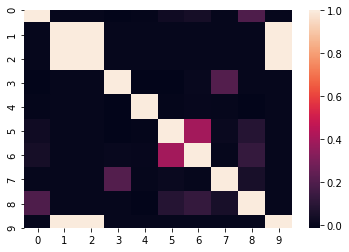

Key:
0 Mr . Woodhouse had so completely made up his mind to the visit , that in spite of the increasing coldness , he seemed to have no idea of shrinking from it , and set forward at last most punctually with his eldest daughter in his own carriage , with less apparent consciousness of the weather than either of the others ; too full of the wonder of his own going , and the pleasure it was to afford at Randalls to see that it was cold , and too well wrapt up to feel it .
1 " Oh !
2 " Oh no , no !
3 Such was Jane Fairfax ' s history .
4 " That has been a good deal the case , my dear ; but not to the degree you mention .
5 " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
6 " And here is Mrs . Weston and Mr . Frank Churchill too ! Quite delightful ; so many friends !"
7 " You may well class the delight , the honour , and the comfo

In [26]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_test).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])
